# 模型调参和人脸识别

前面我们用iris数据集构造了一个数据集，那么下面将会介绍一下模型调参的方法和人脸识别公开数据集的尝试

~~直接ResNet200干他妈的~~ 尝试使用SVM来一轮

**注意：前两个网格搜索和随即网格搜索所利用的数据都是sklearn人脸识别里面的数据而不是iris的数据。**而后面绘制ROC数据则是来自乳腺癌数据集

In [23]:
# 使用网格搜索进行超参数调优：
# 方式1：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import time

#X = iris.data
#y = iris.target

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：274.708 S
0.8657097868217054
{'svc__C': 100.0, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [24]:
# 方式2：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
# param_grid = [{'svc__C':param_range,'svc__kernel':['linear','rbf'],'svc__gamma':param_range}]
gs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

随机网格搜索经历时间：34.913 S
0.8470809108527131
{'svc__kernel': 'linear', 'svc__C': 1000.0}


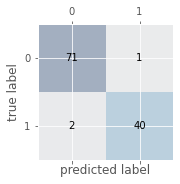

In [25]:
# 混淆矩阵：
# 加载数据
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
'''
乳腺癌数据集：569个恶性和良性肿瘤细胞的样本，M为恶性，B为良性
'''
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()    #将M-B等字符串编码成计算机能识别的0-1
y = le.fit_transform(y)
le.transform(['M','B'])
# 数据切分8：2
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### ROC曲线
ROC曲线的全称是Receiver Operating Curve。中文名是「受试者工作特征曲线」。ROC来源于军事领域，而后在医疗领域运用很广 ~~感觉很多曲线都在医疗领域用的很广，你看吴恩达很多例子都举的医学例子，癌症什么的，这里实际上也是用的癌症的例子。~~

ROC的横坐标为假阳率（FPR，False Positive Rate）；纵坐标为真阳率（TPR，True Positive Rate）。FPR和TPR的计算方法为：

* $FPR = \frac{FP}{N}$ 

* $TPR = \frac{TP}{P}$

其中，P是真实的正样本的数量，N是真实的负样本的数量。

举个🌰：假如有10个疑似癌症患者，其中有三个确实是癌症患者（P = 3），另外七个不是癌症患者（N = 7）。医院对这10个疑似患者做了诊断，对于诊断出的三位癌症患者，其中有两位是真正的癌症患者（TP = 2），那么真阳率$TPR = \frac{TP}{P} = \frac{2}{3} $；有一位是被误诊的癌症患者（FP = 1），那么假阳率就是$FPR = \frac{FP}{N} = \frac{1}{7}$。对于这个分类器「医院」来说，这组分类结果就对应了ROC上的一个点$(\frac{1}{7}, \frac{2}{3})$.

<Figure size 432x288 with 0 Axes>

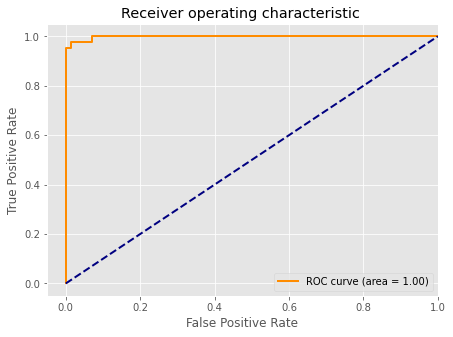

In [26]:
# 绘制ROC曲线：
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()


## 总归是得来点实战
`sklearn.datasets.fetch_lfw_people`是一个人脸识别问题的数据库，我们可以在sklearn中获取。每张图片都有人名Label标记。每个人可能有多张不同情况下情景下的图片。下面是sklearn官网对这个数据集的描述。

![image.png](WX20210328-233403@2x.png)

![](WX20210328-233604@2x.png)

![](WX20210328-233645@2x.png)

然后我们就可以获得很多很有用的信息。

* 5749个人，总计13233张图片
* 维度是5828，通过下面的分辨率我们可以知道这是二值图片
* 每个点的feature范围是0～255 ~这个没啥好解释了吧···~

[关于这个api的中文网站](https://scikit-learn.org.cn/view/506.html)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use("ggplot")      
import seaborn as sns
import sklearn

In [7]:
#下载数据
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people() #注意这里没筛选，是用了全部的数据。

In [8]:
print(faces.target_names)
print(faces.images.shape)

['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']
(13233, 62, 47)


所以可以看到总共有5749个label，那么如果要把这些全部分出来会是一个很大的计算量，因为要做5749分类。同时在很多资料中显示这个dataset的分类都是限定出现label次数为60的人，也就是7个label。那么可以打印这个label的统计信息出来看一看为什么大家都会选择这么操作。

In [9]:
import numpy
import pandas as pd
from collections import Counter

df = pd.DataFrame(faces.target_names)

df.value_counts()

Zydrunas Ilgauskas             1
Glenn Rivers                   1
Gilberto Rodriguez Orejuela    1
Gilberto Simoni                1
Gilles Panizzi                 1
                              ..
Miguel Angel Rodriguez         1
Miguel Contreras               1
Miguel Cotto                   1
Miguel Estrada                 1
AJ Cook                        1
Length: 5749, dtype: int64

In [10]:
df.sort_values(0)

,0
0,AJ Cook
1,AJ Lamas
2,Aaron Eckhart
3,Aaron Guiel
4,Aaron Patterson
...,...
5744,Zorica Radovic
5745,Zulfiqar Ahmed
5746,Zumrati Juma
5747,Zurab Tsereteli


**好吧，我是垃圾，我黔驴技穷了。我用了几种方法都没办法实现降序输出，都是按照首字母而不是按照出现顺序**，我决定放弃，直接按照官方示例来走。
最后给出这个方法的官方文档。[panda.counts()用法](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html)

要注意`faces.target_names`是numpy格式，要转化成dataframe才能使用这个方法。

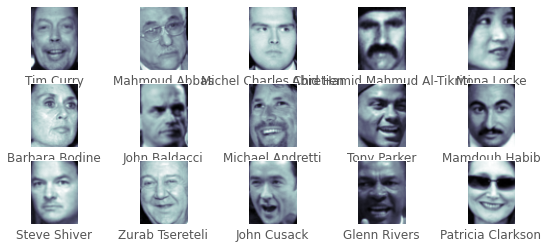

In [11]:
# 那下面就打印几张图看看
fig, ax = plt.subplots(3,5)
fig.subplots_adjust(left=0.0625, right=1.2, wspace=1)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])


接下来我们可以计算人脸数据集上的PCA（特征脸），注意这是一个无监督学习的特征提取/降维。

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time
import logging

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 2.736s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


In [17]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)



Fitting the classifier to the training set
done in 42.628s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


Fitting the classifier to the training set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       1.00      0.81      0.89        36

         accuracy                           0.85       322
        macro avg       0.88      0.72      0.78       322
     weighted avg       0.86      0.85      0.85       322



Text(91.68, 0.5, 'predicted label')

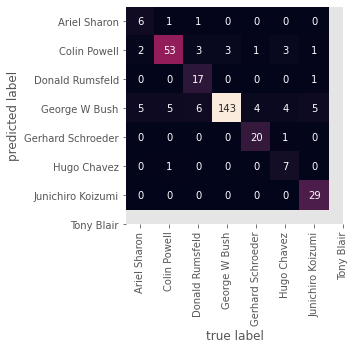

In [19]:
# 训练一个SVM分类模型

print("Fitting the classifier to the training set")

y_pred = clf.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

from sklearn.metrics import confusion_matrix

faces1 = fetch_lfw_people(min_faces_per_person = 60)

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces1.target_names,
            yticklabels=faces1.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label') #打印那七个混淆矩阵

可以看到上面这个输出显示了这个模型针对出现的最常见的七张脸的预测。在这里我们可以回顾一下precision，recall，F1和support的含义：

* precision：预测为正且分类正确的样本占预测值为正的比例，即：$PRE = \frac{TP}{TP+FP}$.  
* recall: 预测为正且分类正确的样本占类别为正的比例，即：$REC =  \frac{TP}{TP+FN}$. 
* F1-score: 综合衡量精度和召回率，即：$F1 = 2\frac{PRE\times REC}{PRE + REC}$. 
* support:表示某个项集出现的频率，在这里指的是这张脸出现的次数

Text(89.17999999999999, 0.5, 'predicted label')

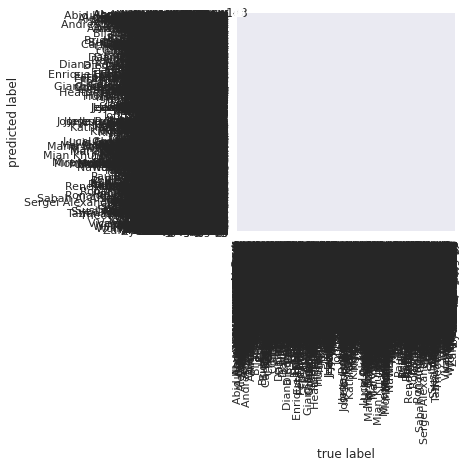

In [71]:
#这里是打印全部数据的混淆矩阵
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

上面这个是我突发奇想想看一看全部数据的混淆矩阵。因为既然我们仅仅选择了至少出现过60次的人脸，也就是筛选出来了出现最多的七张人脸，但是实际上既然有五千多张人脸，那么这个数据的稀疏度灰很高很高，在分类问题中这会对我们造成很大的一个影响。然后可以看到打印出来就是这个样子···基本没法看。另外用全部数据来SVM的话也要好久···我的服务器时48核96线程的E5都跑了好久···要是放本地跑估计我电脑风扇要炸掉···

In [20]:
#使用matplotlib对预测进行定性评估

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

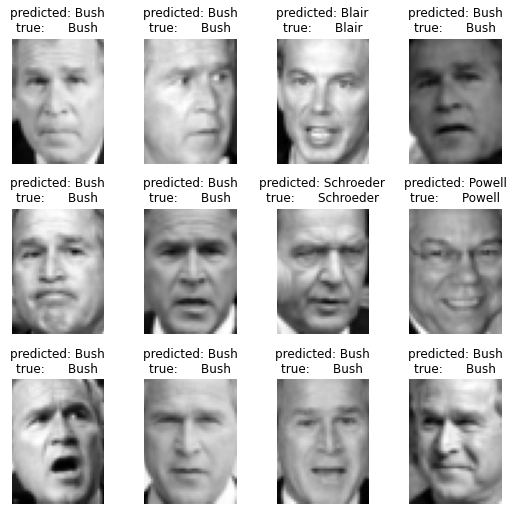

In [21]:
# 打印一部分测试集结果

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

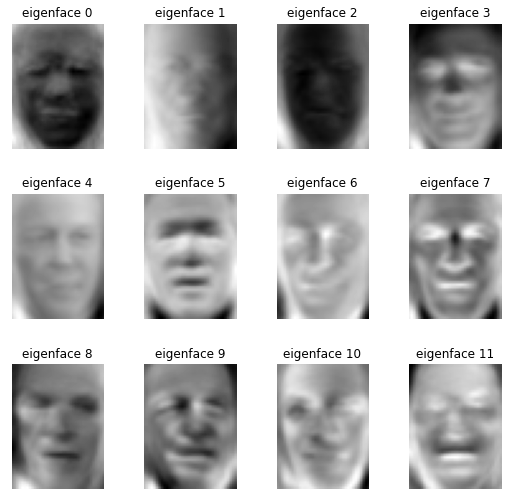

In [22]:
#画出面部特征
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()